In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
from scipy.optimize import curve_fit

In [2]:
Ds=np.arange(12)*0.1;
Fs=np.array([1,2,4,8,16,32,64]);

In [1]:
## LOTKA VOLTERRA SIMULATIONS

def LV( t, n, rij, aij, d, thres=0):
    n = n*(n>thres);
    dn = n*rij*( 1 - np.sum( aij *n, axis=1 ) )-d * n;
    return dn
def LVrun(Rscale, Ascale, lowhigh, Sg=10, Ss=80, D=0.95, nsim=50, th=0, short=True, debug=False):
    # Rscale: mean growth rates of gens and sps 
    # Ascale: min gen aij, min sp aij, min gen-sp aij, max gen-sp aij
    G = Sg; S= Sg+Ss;
    if(debug):
        nsim=1;
    nss = np.zeros((6,nsim,S));
    for k in tqdm(np.arange(nsim) ):
        Ri = np.ones(S)*Rscale[0];#*np.random.uniform( lowhigh[0], lowhigh[1], size=S );
        Aij = np.random.uniform( Ascale[2], Ascale[3], size=(S,S) );
        Aij[:G, :G] =np.random.uniform( Ascale[0], Ascale[1], size=(G,G) );
        Aij[:G, G:] =np.random.uniform( Ascale[4], Ascale[5], size=(G,S-G) );
        Aij[G:, :G] =np.random.uniform( Ascale[6], Ascale[7], size=(S-G,G) );
        for i in np.arange(S):
            Aij[i,i]=1;
        Ri[G:] = 0;
        for i in np.arange(6) :
            nr = [1,2,4,8,15,16][i];
            Ri[:Sg + int((Ss)/16)*nr] = Rscale[1];#*np.random.uniform( lowhigh[0], lowhigh[1], size=int((S-G)/NC) );
            def LV_wrap(t,n):
                return LV(t, n, rij=Ri, aij=Aij, d=D, thres=th)
            sol = solve_ivp( LV_wrap, ( 0, 2e4 ), y0=np.random.uniform(1e-7, 1e-6, size=S), method='Radau' );
            nss[i,k,:] = sol.y[:,-1];
            #nss[i,k,:] = nss[i,k,:]/np.sum(nss[i,k,:]);
    return nss, sol

In [4]:
## LINEAR CONSUMER RESOURCE SIMULATIONS

def LRC( t, nc, rij, aij, c0, d, thres=0):
    nc = nc*(nc>thres);
    n = nc[:rij.shape[0]]; c=nc[rij.shape[0]:];
    dn = n*np.matmul( rij, c )-d * n;
    dc = -c*np.matmul( n, aij*rij)+d*(c0-c);
    return np.concatenate([dn,dc])

def LRCrun(Rscale=np.array([1,0.1]), Ascale=np.array([1,1]), Ns=10, Nr=7, nsim=100, ds=Ds, fs=Fs, th=0):
    # Rscale: mean growth rates of gens and sps 
    # Ascale: min gen aij, min sp aij, min gen-sp aij, max gen-sp aij
    
    Kij = np.zeros((Ns,Nr));
    Aij = np.ones((Ns,Nr));
    ncss = np.zeros((8,5,nsim,Ns+Nr));
    for k in tqdm(np.arange(nsim) ):
        Rij = np.random.normal( Rscale[0], Rscale[1], (Ns, Nr) ); 
        for i in np.arange(Ns):
            Rij[i] = Rij[i]/np.sum(Rij[i]);
        for i in np.arange(8):
            for j in np.arange(5):
                T = 24/fs[j];
                d = ds[i]*T/0.25;
                def LRC_wrap(t, nc):
                    return LRC(t, nc, rij=Rij, aij=Aij, c0= np.ones(Nr), d=0, thres=th)
                def LRC_flush(t,nc):
                    return LRC(t, nc, rij=Rij, aij=Aij, c0= np.ones(Nr), d=d, thres=th)
                n0 = np.random.uniform(1e-7, 1e-6, size=Ns); nc0=np.concatenate([n0, np.ones(Nr)]);
                for dilutions in np.arange(6*fs[j]):
                    nc0 = solve_ivp( LRC_wrap, ( 0, T-0.25 ), y0=nc0, method='Radau' ).y[:,-1];
                    nc0 = solve_ivp( LRC_flush, ( 0, 0.25 ), y0=nc0, method='Radau' ).y[:,-1];
                ncss[i,j,k,:] = nc0;
    return ncss

In [4]:
## MONOD CONSUMER RESOURCE SIMULATIONS

def Monod( t, nc, rij, kij, c0, d, m, vd, thres=0):
    nc = nc*(nc>thres);
    n = nc[:rij.shape[0]]; c=nc[rij.shape[0]:];
    ns = np.repeat( n[:,np.newaxis],len(c), axis=1 ); cs=np.repeat( c[:,np.newaxis], len(n), axis=1 ).T;
    dconsume = ns*rij*cs/(kij+cs);
    dn = np.sum( dconsume, axis=1 ) - (d+vd)*n + m;
    dc = -np.sum( dconsume , axis=0 ) + d*(c0-c);
    return np.concatenate([dn,dc])

def Monodrun(Rscale=np.array([1,0.1]), Kscale=np.array([0.001,0.01]), M=0*np.ones(10), Ascale=np.array([1,1]), Ns=10, Nr=7, nsim=100, ds=Ds, fs=Fs, vd=0*np.ones(10), th=0):
    # Rscale: mean growth rates of gens and sps 
    # Ascale: min gen aij, min sp aij, min gen-sp aij, max gen-sp aij
        
    #Aij = np.ones((Ns,Nr));
    ncss = np.zeros((len(ds),len(fs),nsim,Ns+Nr));
    C0 = np.ones(Nr); C0[0]+=0.2;
    for k in tqdm(np.arange(nsim) ):
        Rij = np.random.normal( Rscale[0], Rscale[1], (Ns, Nr) ); 
        for i in np.arange(Ns):
            Rij[i] = Rij[i]/np.sum(Rij[i]);
        Kij = np.random.uniform(Kscale[0], Kscale[1], (Ns, Nr));
        for i in np.arange(len(ds)):
            for j in np.arange(len(fs)):
                T = 24/fs[j];
                d = ds[i]*T/0.25;
                def Monod_wrap(t, nc):
                    return Monod(t, nc, rij=Rij, kij=Kij, c0= C0, d=0, vd=vd, m=M, thres=th)
                def Monod_flush(t,nc):
                    return Monod(t, nc, rij=Rij, kij=Kij, c0= C0, d=d, vd=vd, m=M, thres=th)
                n0 = np.ones(Ns); nc0=np.concatenate([n0, np.ones(Nr)]);
                for dilutions in np.arange(6*fs[j]):
                    nc0 = solve_ivp( Monod_flush, ( 0, 0.25 ), method='RK45',y0=nc0 ).y[:,-1];
                    nc0 = solve_ivp( Monod_wrap, ( 0, T-0.25 ), method='RK45', y0=nc0 ).y[:,-1];
                ncss[i,j,k,:] = nc0;
    return ncss

In [5]:
def shannon(ns, thres=0.0001):
    div = 0;
    #need clipping
    rho = ns[ns > thres]; rho = rho/np.sum(rho);
    for i in np.arange(np.shape(rho)[0]):
        a = rho[i]*np.log(rho[i]);
        if np.isnan(a): a=0;
        elif a>0: a=0;
        div = div-a;
    return div;

def otu(ns, thres=0.0000):
    rho = ns[ns > 0.00]; #rho = rho/np.sum(rho);
    return np.sum( rho > thres );

In [7]:
#ncss_Monod = Monodrun(nsim=100)
ncss_Monod_variabled = Monodrun(vd = np.random.uniform(-0.1, 0.1, size=10), nsim=100)

100%|██████████| 100/100 [2:35:45<00:00, 96.03s/it] 


In [8]:
nss_Monod_migration = Monodrun(M = 0.001*np.ones(10), nsim=100)

100%|██████████| 100/100 [1:46:19<00:00, 63.91s/it]


In [12]:
#np.savez('0915_sim.npz',ncss_Monod = ncss_Monod, ncss_Monod_01 = ncss_Monod_0001, ncss_Monod_01 = ncss_Monod_01)
#np.savez('1006_sim.npz',ncss_Monod = ncss_Monod, ncss_Monod_highinit=ncss_Monod_highinit)
#np.savez('1016_sim.npz', ncss_Monod = ncss_Monod, ncss_Monod_highinit=ncss_Monod_highinit, ncss_Monod_variabled= ncss_Monod_variabled, ncss_Monod_migration = nss_Monod_migration)

In [6]:
loaded=np.load('1016_sim.npz')
ncss_Monod=loaded['ncss_Monod']
ncss_Monod_highinit=loaded['ncss_Monod_highinit']
ncss_Monod_variabled=loaded['ncss_Monod_variabled']
ncss_Monod_migration=loaded['ncss_Monod_migration']

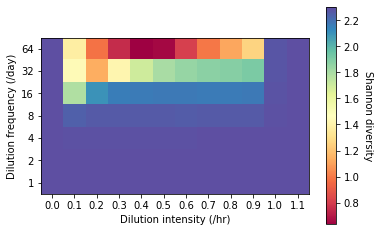

In [17]:
##load saved data
#loaded=np.load('1006_sim.npz')
#ncss_Monod=loaded['ncss_Monod']
#ncss_Monod_highinit=loaded['ncss_Monod_highinit']
##define shannon diversity conversion
def shannon(ns, thres=0.0001):
    div = 0;
    #need clipping
    rho = ns[ns > thres]; rho = rho/np.sum(rho);
    for i in np.arange(np.shape(rho)[0]):
        a = rho[i]*np.log(rho[i]);
        if np.isnan(a): a=0;
        elif a>0: a=0;
        div = div-a;
    return div;
##calculate shannon diversity for a given dataset
sha = np.zeros((12,7));
shs = np.zeros((12,7));
for i in np.arange(12):
    for j in np.arange(7):
        dumi = [];
        for k in np.arange(100):
            dumi = dumi+ [shannon(ncss_Monod_migration[i,j,k,:10], thres=0)]; # can choose data here
        sha[i,j] = np.average(dumi);
        shs[i,j] = np.std(dumi);
## Plot the data via heatmap
fig, ax = plt.subplots()
im = ax.imshow(sha.T, cmap='Spectral')
ax.set_xticks(np.arange(12));
ax.set_xticklabels(np.arange(12)/10);
ax.set_yticks(np.arange(7));
ax.set_yticklabels(2**np.arange(7));
ax.set_ylim(-0.5,6.5)
ax.set_xlabel('Dilution intensity (/hr)');
ax.set_ylabel('Dilution frequency (/day)');
cbar = ax.figure.colorbar(im, ax=ax )
cbar.ax.set_ylabel('Shannon diversity', rotation=-90, va="bottom");
fig.savefig('1016_migration.png',bbox_inches='tight')

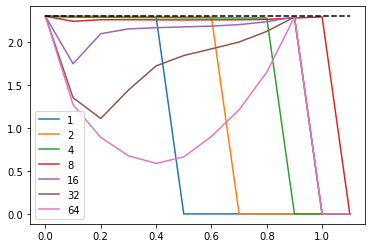

In [16]:
plt.plot(Ds, sha)
plt.legend(Fs)
plt.plot( Ds, sha[:,0]*0+np.log(10), 'k--' )
#plt.savefig('1005_fig1_th0.png',bbox_inches='tight')

In [2]:
class Community:
    '''  Community Generation / Model definition '''
    def __init__(self, Ns = 10, Nr = 7, model=0, dist = np.random.uniform, 
                 dist_param1 = np.array([0.9, 1.1]), dist_param2 = np.array([0.001, 0.01]), norm=False ):
        self.Ns = Ns # number of species
        self.Nr = Nr # number of resource
        self.Model = model # growth model (Monod, Linear, ...)
        self.dist = dist # distribution for species generation
        #self.dist_param = dist_param # parameters for species generation
        self.norm = norm # normalization for summed growth rate over all resources for each species
        self.c0 = np.ones(Nr); self.c0[0]+=0.2 # supplied resource concetrations
        ## There is a caveat on determining c0: if everything is exactly symmetric, then niche flip will turn one coexisting community into
        ## another coexistning community without going through no-coexistence region. Thus I initially made c0[0]=1.2 instead of 1 in order
        ## to introduce asymmetry. This is an arbitrary choice, but I think it might strengthen U-shape.
        ## Also, the scale is set such that maximum growth rate( sum_i Rij*c0j) ~ 1. 
        self.d=0; # dilution rate
        
        if(model == 0): # Monod model
            self.Rij = dist( dist_param1[0]/Nr, dist_param1[1]/Nr, (Ns, Nr) ); # generation of Growth rates, R of i-th species on j-th resource
            self.Kij = dist( dist_param2[0], dist_param2[1], (Ns, Nr) ); # generation of Monod constants, K of i-th species on j-th resource
        elif(model == 1): # LRC model, without cross-feeding, and with uniform yield.
            self.Rij = dist( dist_param1[0]/Nr, dist_param1[1]/Nr, (Ns, Nr) );
            self.Kij = np.zeros((Ns,Nr));
        elif(model == 2): # LV model
            self.Rs = np.ones( Ns );
            self.Aij = np.exp(dist( -np.log(2) , np.log(2), (Ns, Ns)) );
            for i in np.arange(Ns):
                self.Aij[i,i] = 1;
        else: 
            print('Model not implemented')
            self.Rij = np.zeros((Ns,Nr));
            self.Kij = np.zeros((Ns,Nr));
        
    def step(self, nc, t):
        ''' A single timestep dynamics '''
        if(self.Model == 0): # Monod
            dn = np.zeros(self.Ns); dc=np.zeros(self.Nr);
            ns = nc[:self.Ns]; cs=nc[self.Ns:];
            for i in np.arange(self.Ns):
                dn[i] = np.sum( self.Rij[i,:] * cs / (self.Kij[i,:] + cs) )*ns[i] - self.d*ns[i];
            for j in np.arange(self.Nr):
                dc[j] = -np.sum( self.Rij[:,j] * ns * cs[j] / (self.Kij[:,j] + cs[j]) ) - self.d*(cs[j] - self.c0[j] );
            dnc= np.concatenate((dn,dc))   
        elif(self.Model == 1): # Linear
            dn = np.zeros(self.Ns); dc=np.zeros(self.Nr);
            ns = nc[:self.Ns]; cs=nc[self.Ns:];
            for i in np.arange(self.Ns):
                dn[i] = np.sum( self.Rij[i,:] * cs ) * ns[i] - self.d*ns[i];
            for j in np.arange(self.Nr):
                dc[j] = -np.sum( self.Rij[:,j] * ns * cs[j] ) - self.d*(cs[j] - self.c0[j]);
            dnc= np.concatenate((dn,dc));
        elif(self.Model == 2): # LV
            dn = np.zeros(self.Ns); dc=np.zeros(self.Nr);
            ns = nc[:self.Ns]; cs=nc[self.Ns:];
            for i in np.arange(self.Ns):
                dn[i] = self.Rs[i]*(1 - np.sum( self.Aij[i,:]*ns ) );
            dnc = np.concatenate((dn,dc));
        else:
            print('model not implemented')
            dnc = 0;
        return dnc;
    

In [3]:
# For odeint implementation, the simulation runner should be external from class instance that defines the steps for run.
def runner(CI, d, freq, nday, track=False ):
    '''get Community Instance (CI) and run. Mimic the chemostat's 15-min flush protocol'''
    c0 = CI.c0;
    ode = CI.step;
    tmax = 24/freq; tmax1= 0.25; tmax2= tmax-tmax1;
    m = CI.Nr; n=CI.Ns;
    nc0 = np.concatenate((np.ones(n),c0)); 
    deff = d*tmax/tmax1;
    t1=np.linspace(0,tmax1,np.max([tmax1*deff,10])); t2=np.linspace(0,tmax2,np.max([tmax2*deff,10])); 
    if(track):
        ts= np.zeros(1); ns = np.ones((1,n)); cs=np.ones((1,m));
        for i in np.arange(nday*freq):
            CI.d = deff;
            #data = scipy.integrate.odeint(ode, nc0, t1, args = params, mxstep=10000, atol=1e-4); nc0=data[-1];
            data = scipy.integrate.odeint(ode, nc0, t1, mxstep=10000, atol=1e-4); nc0=data[-1];
            nc0 = nc0*(nc0>0);
            ts = np.concatenate((ts, t1+i*tmax)); ns= np.concatenate( (ns, np.array(data[:,:n])), axis=0 ); cs= np.concatenate( (cs, data[:,n:]), axis=0 );
            CI.d = 0;
            data = scipy.integrate.odeint(ode, nc0, t2, mxstep=10000, atol=1e-4); nc0=data[-1];
            nc0 = nc0*(nc0>0);
            ts = np.concatenate((ts, t2+i*tmax)); ns= np.concatenate( (ns, np.array(data[:,:n])), axis=0 ); cs= np.concatenate( (cs, data[:,n:]), axis=0 );
        return [ts, ns, cs]
    else:
        for i in np.arange(nday*freq):
            CI.d = deff;
            data = scipy.integrate.odeint(ode, nc0, t1, mxstep=10000, atol=1e-4); nc0=data[-1];
            nc0 = nc0*(nc0>0);
            CI.d = 0;
            data = scipy.integrate.odeint(ode, nc0, t2, mxstep=10000, atol=1e-4); nc0=data[-1];
            nc0 = nc0*(nc0>0);
        return nc0[:n]
    
def run_multi( nsim=100, ns=10, nr=7, nd=8, nf=5, model=0 ):
    '''Run multiple communities' simulations to get statistics '''
    fs=np.array([1,4,16,32,64]);
    ds=np.arange(nd)*0.1; ds[-1]=0.8;
    nss = np.zeros((nsim, nd, nf, ns));

    start = time.time();
    if(model == 0 or model == 1):
        Rijs = np.zeros((nsim, ns, nr));
        Kijs = np.zeros((nsim, ns, nr));
        for s in np.arange(nsim):
            test = Community(Ns=ns, Nr=nr, model=model);
            Rijs[s,:,:] = test.Rij;
            Kijs[s,:,:] = test.Kij;
            for i in np.arange(nd):
                for j in np.arange(nf):
                    nss[s, i, j, :] = runner(test, ds[i], fs[j], 6, track=False)
        end = time.time();
        print(end-start)
        return nss, Rijs, Kijs
    elif(model==2):
        Rss = np.zeros((nsim, ns));
        Aijs = np.zeros((nsim, ns, ns));
        for s in np.arange(nsim):
            test = Community(Ns=ns, Nr=nr, model=model);
            Rss[s,:] = test.Rs;
            Aijs[s,:,:] = test.Aij;
            for i in np.arange(nd):
                for j in np.arange(nf):
                    nss[s, i, j, :] = runner(test, ds[i], fs[j], 6, track=False)
        end = time.time();
        print(end-start)
        return nss, Rss, Aijs
    else:
        print('Model not implemented')